In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [2]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 38.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [3]:
import keras
keras.__version__

'3.3.3'

In [4]:
import keras
from keras import Sequential, Input, Model
from keras import ops
from keras.layers import InputLayer, Conv2D, Dense, Flatten, Reshape, Conv2DTranspose, LeakyReLU, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.utils import plot_model
from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio

In [5]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

In [7]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


In [8]:

discriminator = Sequential(
    [
        InputLayer((28, 28, discriminator_in_channels)),
        Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        LeakyReLU(negative_slope=0.2),
        Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        LeakyReLU(negative_slope=0.2),
        GlobalMaxPooling2D(),
        Dense(1),
    ],
    name="discriminator",
)


generator = Sequential(
    [
        InputLayer((generator_in_channels,)),
        Dense(7 * 7 * generator_in_channels),
        LeakyReLU(negative_slope=0.2),
        Reshape((7, 7, generator_in_channels)),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        LeakyReLU(negative_slope=0.2),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        LeakyReLU(negative_slope=0.2),
        Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [9]:

class cGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(27)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data


        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )


        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )


        generated_images = self.generator(random_vector_labels)


        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )


        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )


        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )


        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )


        misleading_labels = ops.zeros((batch_size, 1))


        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))


        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


In [10]:
cond_gan = cGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=Adam(learning_rate=0.0003),
    g_optimizer=Adam(learning_rate=0.0003),
    loss_fn=BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=50)

Epoch 1/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - d_loss: 0.4298 - g_loss: 1.4889
Epoch 2/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - d_loss: 0.5229 - g_loss: 1.2095
Epoch 3/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - d_loss: 0.4065 - g_loss: 1.4938
Epoch 4/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - d_loss: 0.2413 - g_loss: 2.1932
Epoch 5/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - d_loss: 0.5999 - g_loss: 1.0437
Epoch 6/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - d_loss: 0.6497 - g_loss: 0.9271
Epoch 7/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - d_loss: 0.6644 - g_loss: 0.8373
Epoch 8/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - d_loss: 0.6662 - g_loss: 0.8154
Epoch 9/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - d_loss: 0.6704 - g_loss: 0.7955
Epoch 10/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - d_loss: 0.6722 - g_loss: 0.7829
Epoch 11/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - d_loss: 0.6762 - g_loss: 0.7787
Epoch 12/50
1094/1094 ━━━━━━

In [11]:
# We first extract the trained generator from our Conditional GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9
# Sample noise for the interpolation.
interpolation_noise = keras.random.normal(shape=(1, latent_dim))
interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = ops.cast(first_label, "float32")
    second_label = ops.cast(second_label, "float32")

    # Calculate the interpolation vector between the two labels.
    percent_second_label = ops.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = ops.cast(percent_second_label, "float32")
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = ops.concatenate([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 3
end_class = 7
fake_images = interpolate_class(start_class, end_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step



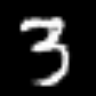

In [12]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = ops.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images[:, :, :, 0], fps=1)
embed.embed_file("animation.gif")